In [41]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.tsa.api as sts

tweet_data = pd.read_csv('tweets_01-08-2021.csv')

In [42]:
#Converting the 'date' column into a datetime variable 
#and appending the new column to the dataframe
tweet_data["datetime"]=tweet_data["date"].apply(lambda x : dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
tweet_data["month_year"]=tweet_data["datetime"].apply(lambda x : str(x.month)+"-"+str(x.year))
tweet_data.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,datetime,month_year
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f,2011-08-02 18:07:48,8-2011
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f,2020-03-03 01:34:50,3-2020
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f,2020-01-17 03:22:47,1-2020
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f,2020-09-12 20:10:58,9-2020
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f,2020-01-17 13:13:59,1-2020


In [43]:
#2. When did Trump start tweeting from an iPhone?
iphone_tweet_dates=tweet_data[tweet_data["device"]=="Twitter for iPhone"]["datetime"]
print(f"Trump started tweeting from an iPhone on {min(iphone_tweet_dates).date()} at {min(iphone_tweet_dates).time()}")

Trump started tweeting from an iPhone on 2012-12-11 at 01:20:01


In [44]:
def tweet_keyword_occurrences(keyword_list):
    '''
    This function searches for every keyword in the list passed as argument
    within the parent dataframe and returns a dataframe that only contains 
    tweets that have those keywords in them.

    PARAMETERS
    -------------------------
    keyword_list: list
    List of keywords to search for in the tweet_data dataframe.

    RETURNS
    -------------------------
    pandas dataframe
    A copy of the parent dataframe that only contains logs of tweets
    that contain the specified keywords within them.
    '''
    return tweet_data[tweet_data["text"].str.contains('|'.join(keyword_list), case=False)] 

In [45]:
#3. How many tweets has Trump posted about immigration?
keywords=['immigrant', 'immigrants', 'immigration']
immigration_tweets=tweet_keyword_occurrences(keywords)
print(f"Trump has posted {immigration_tweets.shape[0]} tweets about immigration.")

Trump has posted 433 tweets about immigration.


In [46]:
#4. How many of Trump’s tweets mention Fox News?
fox_news_mention_keywords=['@foxnews', '@foxandfriends', '@oreillyfactor', '@seanhannity', '@mariabartiromo', '@ingrahamangle']
fox_news_tweets=tweet_keyword_occurrences(fox_news_mention_keywords)
print(f"{fox_news_tweets.shape[0]} of Trump's tweets mention Fox News.")

2151 of Trump's tweets mention Fox News.


In [47]:
#5. How many of Trump’s tweets mention the show “The Apprentice”?
apprentice_mention_keywords=['@apprenticenbc', '@celebapprentice']
apprentice_tweets=tweet_keyword_occurrences(apprentice_mention_keywords)
print(f"{apprentice_tweets.shape[0]} of Trump's tweets mention the show \"The Apprentice\".")

534 of Trump's tweets mention the show "The Apprentice".


In [48]:
def frame_month_year_aggregator(df, name):
    '''
    This function groups the number of tweets made within a month and
    adds a column to the passed dataframe containing the count of said
    tweets in a given month

    PARAMETERS
    ------------------------
    df: pandas dataframe
    The dataframe to be modified. Contains a subset of the twitter log data

    name: string
    The name of the type of tweets contained in the dataframe
    
    RETURNS
    ------------------------
    pandas dataframe
    A dataframe containing a new column containing the count of tweets
    posted within a given month  

    '''
    return df.groupby(["month_year"]).agg({"id":"count"}).reset_index().rename(columns ={"id":"count_"+name})

In [49]:
immigration_tweets_agg=frame_month_year_aggregator(immigration_tweets, "immigration_tweets")
fox_news_tweets_agg=frame_month_year_aggregator(fox_news_tweets, "fox_news_tweets")
apprentice_tweets_agg=frame_month_year_aggregator(apprentice_tweets, "apprentice_tweets")

time_series_plot_data=immigration_tweets_agg.merge(fox_news_tweets_agg.merge(apprentice_tweets_agg, on="month_year", how="outer"), on="month_year", how="outer").fillna(0)

Text(0.5, 1.0, 'Time series data showing number of tweets per keyword mentions by month')

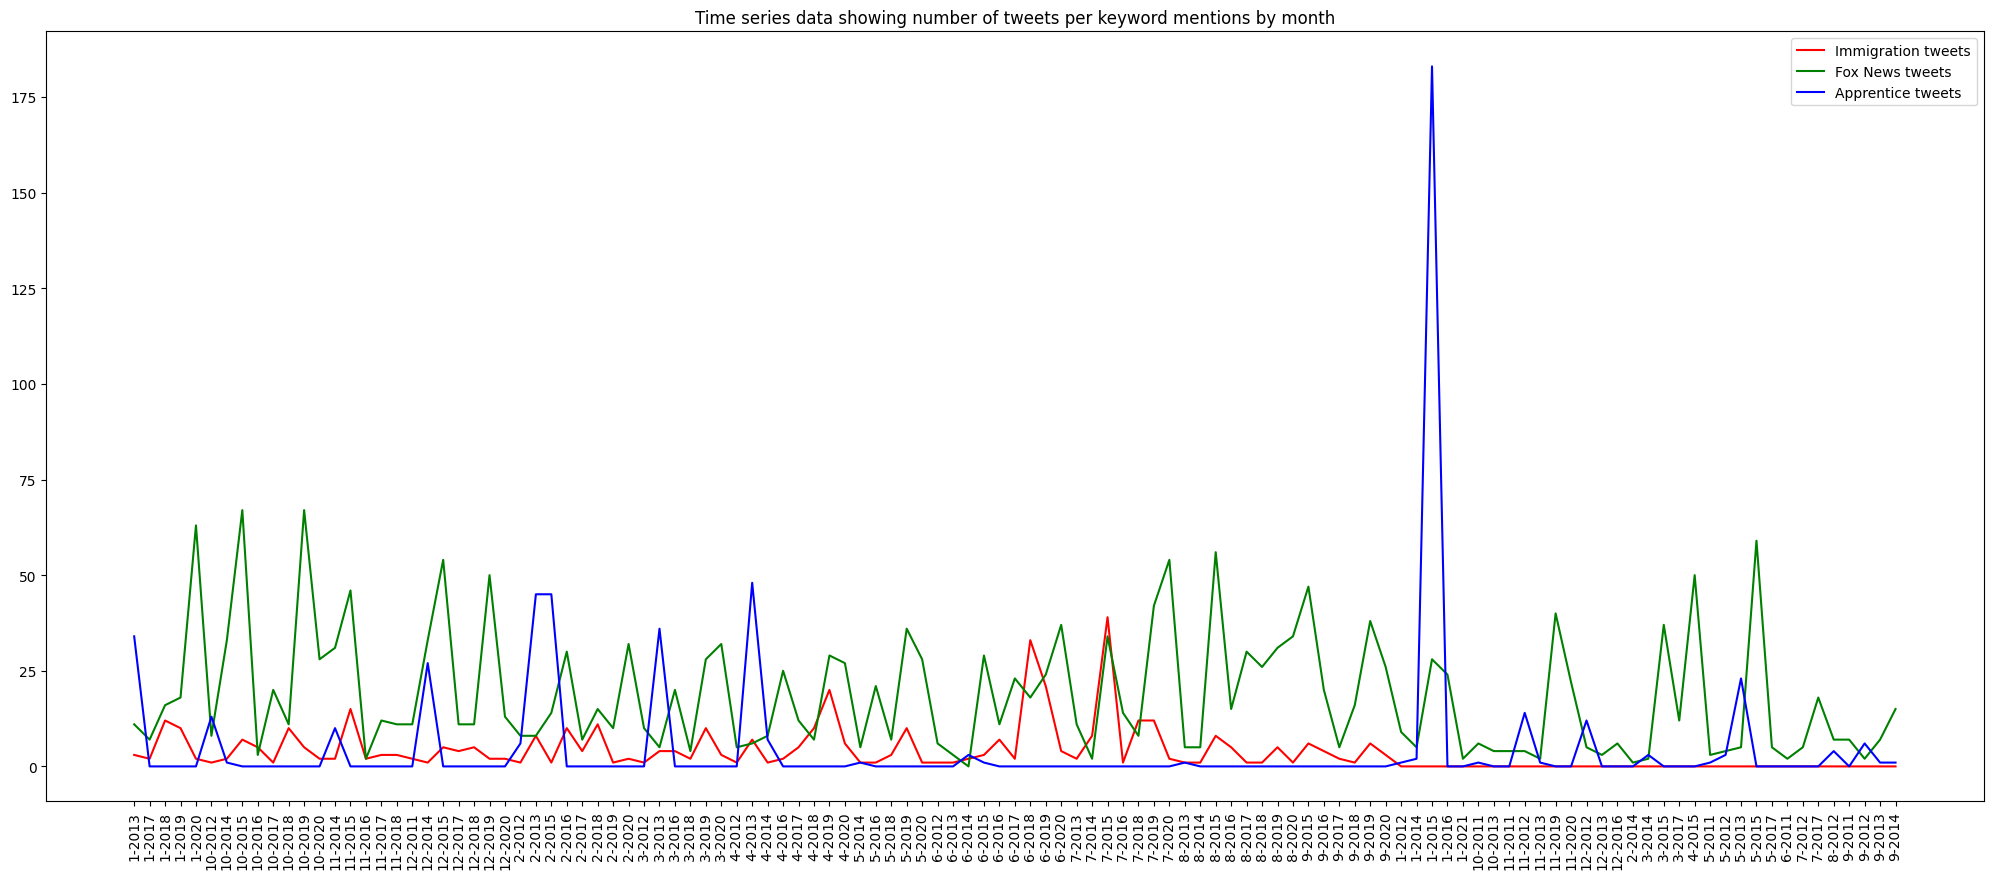

In [50]:
plt.rcParams["figure.figsize"]=(25,10)
plt.plot(time_series_plot_data["month_year"], time_series_plot_data["count_immigration_tweets"], color='r', label="Immigration tweets")
plt.plot(time_series_plot_data["month_year"], time_series_plot_data["count_fox_news_tweets"], color='g', label="Fox News tweets")
plt.plot(time_series_plot_data["month_year"], time_series_plot_data["count_apprentice_tweets"], color='b', label="Apprentice tweets")
plt.xticks(rotation=90)
plt.legend()
plt.title("Time series data showing number of tweets per keyword mentions by month")

In [51]:
sts.stattools.grangercausalitytests(time_series_plot_data[["count_immigration_tweets", "count_fox_news_tweets"]], maxlag=1 , addconst=True)

# Based on the p values observed through this causality test (all of which are
# significantly more than 0.05), we can safely reject the null hypothesis
# and confidently say that Trump's mention of Fox News in his tweets did NOT
# act as a significant predictor of him tweeting about immigration in the 
# following month. 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4430  , p=0.2322  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=1.4820  , p=0.2235  , df=1
likelihood ratio test: chi2=1.4724  , p=0.2250  , df=1
parameter F test:         F=1.4430  , p=0.2322  , df_denom=111, df_num=1


{1: ({'ssr_ftest': (1.442960403130599, 0.23221776602375147, 111.0, 1),
   'ssr_chi2test': (1.4819593329449394, 0.223468217944988, 1),
   'lrtest': (1.4724095352112272, 0.22496590781357595, 1),
   'params_ftest': (1.4429604031305783, 0.2322177660237488, 111.0, 1.0)},
   array([[0., 1., 0.]])])}

In [52]:
sts.stattools.grangercausalitytests(time_series_plot_data[["count_immigration_tweets", "count_apprentice_tweets"]], maxlag=1 , addconst=True)

#Since the p values are significantly more than 0.05, we can confidently 
#state that Trump mentioning The Apprentice in the previous month was NOT
#a significant predictor of him tweeting about immigration in the following
#month 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2648  , p=0.6079  , df_denom=111, df_num=1
ssr based chi2 test:   chi2=0.2719  , p=0.6020  , df=1
likelihood ratio test: chi2=0.2716  , p=0.6023  , df=1
parameter F test:         F=0.2648  , p=0.6079  , df_denom=111, df_num=1


{1: ({'ssr_ftest': (0.2647754314717014, 0.6078812355547889, 111.0, 1),
   'ssr_chi2test': (0.2719315242141798, 0.6020390227971363, 1),
   'lrtest': (0.2716077111854247, 0.602255339439602, 1),
   'params_ftest': (0.26477543147168375, 0.6078812355547972, 111.0, 1.0)},
   array([[0., 1., 0.]])])}

In conclusion, the Granger causality tests tell us that Fox News had **very little influence** on Trump with regards to his talk about immigration. There are, however, alternative explanations that can be explored to investigate any potential causality further:
- There could be a greater time delay between the Granger causation, something that can be tested for by inputting different time lags between the time series datasets.
- Trump tweeting/mentioning Fox News in his tweets may not be a good enough indicator of him being influenced by them. We do not know average sentiment within the tweets these mentions were made, neither has there been any text analysis to better understand the context in which these tweets have been made. 